# Evolution de l'émission du centre galactique et de l'émission diffuse

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

# Début de l'analyse (avec mapdatasets déjà écrits)

### Création de la géométrie

In [4]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

energy_axis_true = MapAxis.from_bounds(
    0.1, 200, 20, unit="TeV", name="energy", interp="log"
)

### Lecture des cartes

In [5]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "$GAMMAPY_DATA/mapdataset_hess/mapsdataset_120arcmin_bkg_renorm/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(filename)

### Modèle de la source

In [6]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

spatial_model = PointSpatialModel(
            lon_0 = src_pos.l, 
            lat_0 = src_pos.b, 
            frame = "galactic")

spectral_model = PowerLawSpectralModel(
            #emin = 0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "1.26e-12 cm-2 s-1 TeV-1")

model = SkyModel(
            spatial_model = spatial_model, 
            spectral_model = spectral_model, 
            name = "SgrA*")

model.parameters["index"].frozen = True
model.parameters["lon_0"].frozen = True
model.parameters["lat_0"].frozen = True

### Modèle de l'émission diffuse

- on prend une carte de la distribution du CS comme base
- on applique une gaussienne pour "atténuer" les bords, car l'émission de rayons gamma suit la distribution du CS à part aux extrémités du "disque centrale"
- on choisit 0.8 deg comme écart-type de la gaussienne
- on seuil les valeurs de la cartes du CS, car celles-ci viennent de données bruitées qui peuvent prendre des valeurs négatives, on veut a priori seuiller un peu au dessus de zéro pour éliminer le bruit autour de zéro
- valeur du seuil : 10
- le fait d'utiliser TemplateSpatialModel en 0.15 conduit à normaliser les valeurs de la carte par leur somme (normal car on va fiter son amplitude), mais aussi par la somme des angles solides, ce qui fait que le spectre obtenu est en sr-1 emais ce n'est précisé nulle part

In [7]:
CSmap = Map.read("$GAMMAPY_DATA/CS_reproj.fits") 


# à moduler par une gaussienne en longitude
coords = CSmap.geom.get_coord()
lon = coords.skycoord.l.wrap_at(180*u.deg).to_value('deg')
factor = np.exp(-0.5*(lon)**2/0.8**2)


# seuiller les valeurs pour enlever les valeurs négatives liées au bruit
CSmap.data*=factor
CSmap.data = CSmap.data.clip(10.0)

# utile pour retrouver la bonne valeur du flux diffus (intégré sur l'angle solide)
solid_angle_tot = CSmap.geom.solid_angle().sum()

# utile ?
#totalCS = CSmap.quantity*CSmap.geom.solid_angle()
#CSmap.data = CSmap.data/totalCS.value


diffuse_gal = TemplateSpatialModel(CSmap)

#diffuse_gal.parameters["norm"].value = 1.0

powerlaw2 =  PowerLawSpectralModel(
            #emin =0.5* u.TeV, 
            #emax = 100* u.TeV, 
            reference = 1.0 * u.TeV,
            index = 2.3, 
            amplitude = "4.2e-12 cm-2 s-1 TeV-1")


model_diff = SkyModel(
            spatial_model = diffuse_gal, 
            spectral_model = powerlaw2, 
            name = "DE")

model_diff.parameters["index"].frozen = True
model_diff.parameters["norm"].frozen = True

Invalid value BUNIT='Count' in FITS header. Setting empty unit.


### Construction du masque

In [8]:
fit_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg)

g0901_region = CircleSkyRegion(SkyCoord(0.8791,  +0.0893, unit="deg", frame="galactic"), 0.1*u.deg)

bizarre_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.4 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([g0901_region ,bizarre_region ] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Création des fausses cartes

In [9]:
for year in range(2004,2020):
    mapdataset_dict[year].models =  model.copy() + model_diff.copy()
    mapdataset_dict[year].fake()

In [9]:
print(mapdataset_dict[2004])

MapDataset

    Name                            :  

    Total counts                    : 183507 
    Total predicted counts          : 182426.95
    Total background counts         : 169294.31

    Exposure min                    : 3.57e+05 m2 s
    Exposure max                    : 5.31e+10 m2 s

    Number of total bins            : 4000000 
    Number of fit bins              : 1862080 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : 631509.36

    Number of models                : 3 
    Number of parameters            : 12
    Number of free parameters       : 3

    Component 0: 
        Name                        : SgrA*-copy
        Type                        : SkyModel
        Spatial  model type         : PointSpatialModel
        Spectral model type         : PowerLawSpectralModel
        Parameters:
            lon_0        (frozen)   : 359.940  deg
            lat_0        (frozen)   : -0.040  deg
            index        (frozen)   : 

# Ajustement du modèle aux cartes

Pour les cartes fabriquées avec le FOVBackgroundMaker : 
- si la norm du background est frozen = emission diffuse est négative
- si la norm du background est pas frozen = emission diffuse est négative au premier essai
- emission diffuse est idem au deuxième essai
- emission diffuse est idem   au troisième essai
- si la norm du background est pas frozen ET qu'on ne refixe pas norm à 1 = emission diffuse est ok/bof au quatrième essai
- si on le refait (toujours sans toucher à la norm mais avec reset des 2 modèles) = c'est bon


En gros, faire le fit une première fois pour avoir la norm juste, puis, sans toucher à la norm, remettre les deux modèles à zéro et refaire le fit, deux fois

si on refait le fit sans mettre les modèles à zéro ? ça change rien (logique car à cette étape le fit est censé être correct)

In [17]:
for year in range(2004,2020):
    mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =  model.copy() + model_diff.copy()
    #mapdataset_dict[year].background_model.parameters['norm'].value = 1.0
    mapdataset_dict[year].background_model.parameters['norm'].frozen = False
    mapdataset_dict[year].models[1].parameters['amplitude'].frozen = False

In [18]:
print(mapdataset_dict[2004].models)

SkyModels

Component 0: SkyModel

   name     value    error      unit         min        max    frozen
--------- ---------- ----- -------------- ---------- --------- ------
    lon_0  3.599e+02   nan            deg        nan       nan   True
    lat_0 -4.000e-02   nan            deg -9.000e+01 9.000e+01   True
    index  2.300e+00   nan                       nan       nan   True
amplitude  1.260e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference  1.000e+00   nan            TeV        nan       nan   True

	

Component 1: SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
     norm 1.000e+00   nan                nan nan   True
    index 2.300e+00   nan                nan nan   True
amplitude 4.200e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True

	




In [19]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    rescov = fit.covariance()
    ampSGRA = mapdataset.models.parameters[3]
    ampdiff = mapdataset.models.parameters[7]
    normbkg = mapdataset.background_model.parameters['norm']
    
    cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, cov

def fit_dataset_contour(mapdataset):
    fit = Fit([mapdataset])

    fit.optimize()
    res = fit.minos_contour(3, 7)
   
    return res

In [20]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()


for year in range(2004,2020):
    
    table, cov = fit_dataset(mapdataset_dict[year])
    
    results_per_year[year] = table
    
    cov_per_year[year] = cov


CPU times: user 9min 21s, sys: 21.3 s, total: 9min 43s
Wall time: 9min 43s


In [13]:
results_per_year[2004]

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,1.290e-12,6.169e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.000e+00,0.000e+00,,nan,nan,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,9.587e-12,8.910e-12,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [14]:
cov_per_year[2004]

array([[ 3.80601424e-27, -1.57226946e-25,  7.13558230e-17],
       [-1.57226946e-25,  7.93855903e-23, -4.04328523e-14],
       [ 7.13558230e-17, -4.04328523e-14,  2.65466666e-05]])

### Sauvegarde des modèles par année

In [21]:
for year in range(2004,2020):
    mapdataset_dict[year].models.write("../../hess_results/simu_1/models/model"+ str(year), overwrite=True)

### Affichage et sauvegarde des résidus

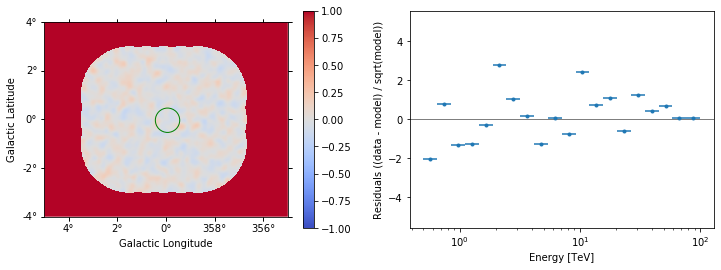

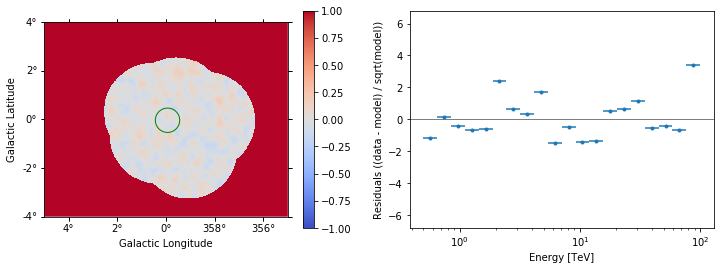

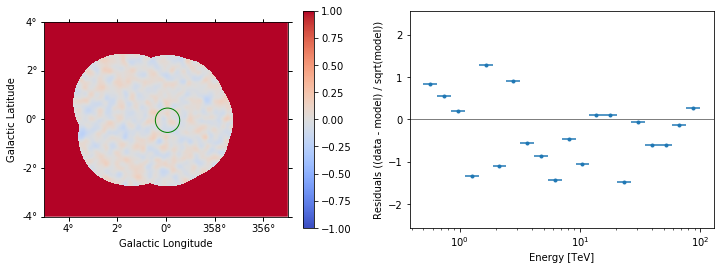

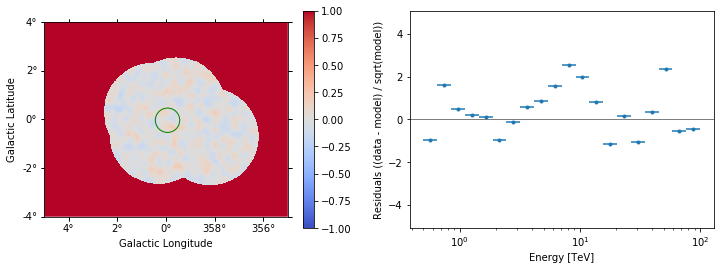

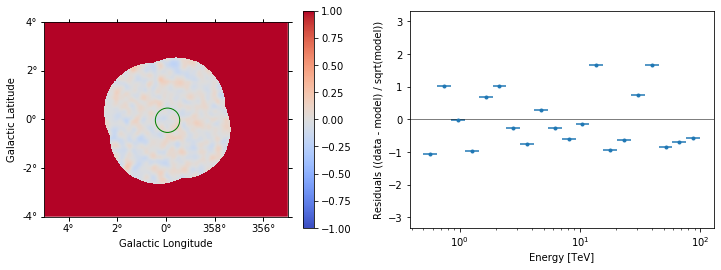

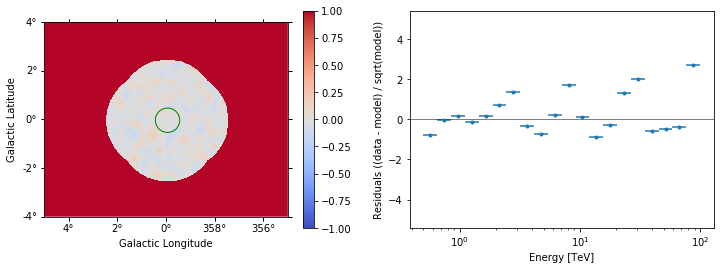

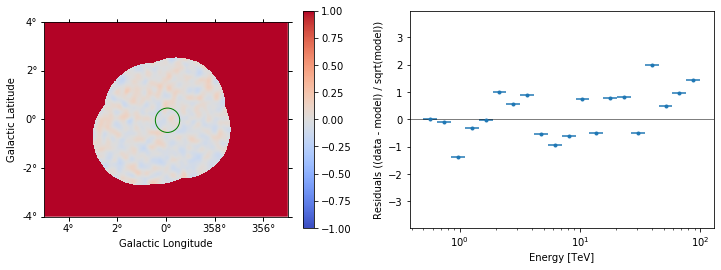

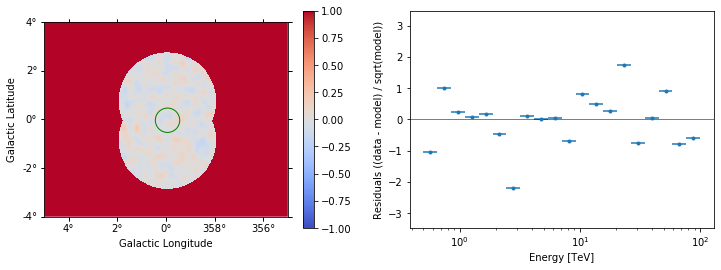

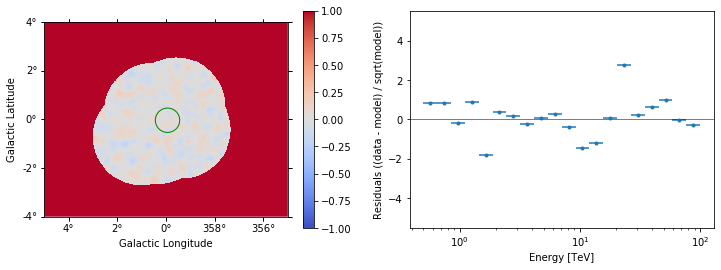

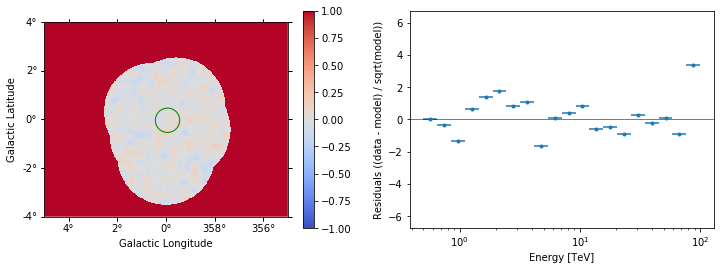

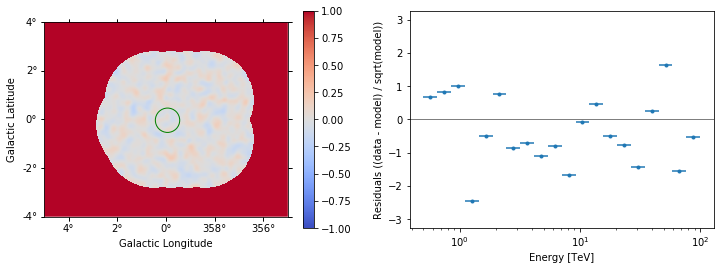

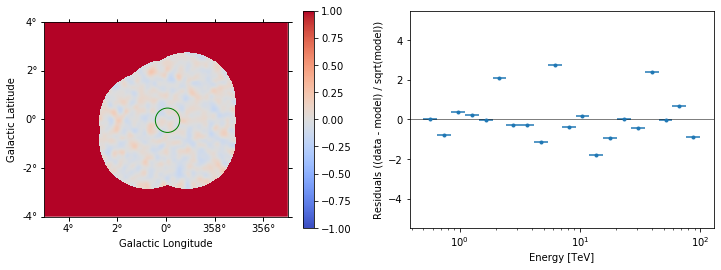

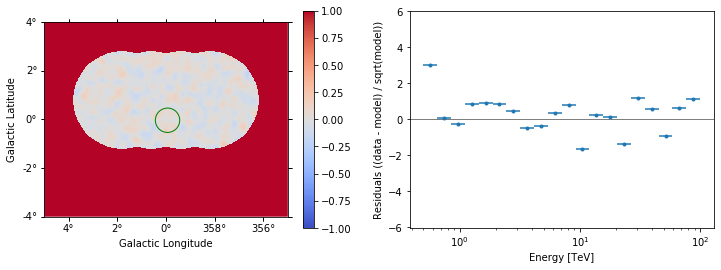

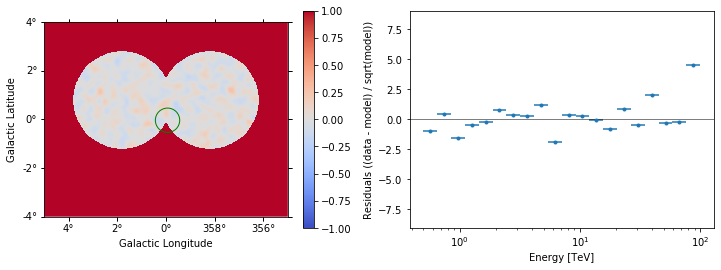

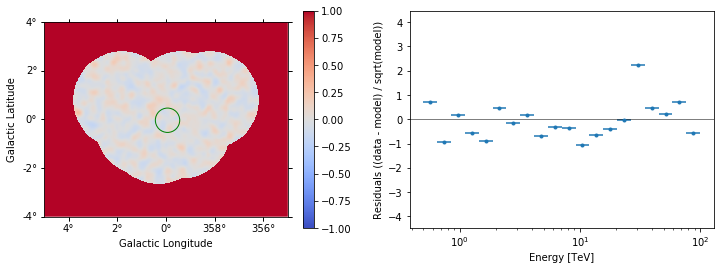

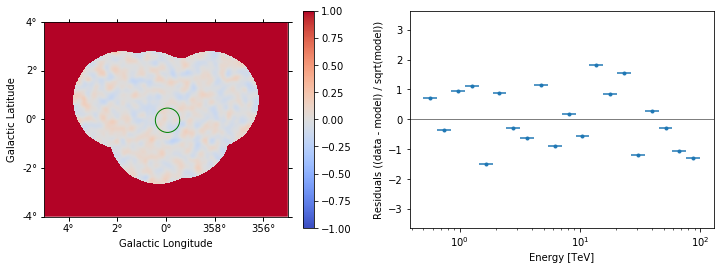

In [20]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

for year in range(2004,2020):
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    #plt.savefig("../../hess_results/simu_1/residuals/residuals_"+str(year)+".pdf", overwrite=True)


## Etude de l'évolution temporelle de la source/du diffus

In [15]:
def CalculateFluxFromModels(year, emin, emax):
    GC_model,diffuse_model  = mapdataset_dict[year].models
    
    amplitudeGC = results_per_year[year]['value'][3]
    amp_errGC = results_per_year[year]['error'][3]
    amplitudediff = results_per_year[year]['value'][7]
    amp_errdiff = results_per_year[year]['error'][7]
    
    if isinstance(emin, u.Quantity):
        #il faut convertir le flux du diffus qui est en sr-1, 
        # donc intégrer sur tout l'angle solide du template (opération inverse de celle effectuée par TamplateSpatialModel)
        
        diffuse_flux = diffuse_model.spectral_model.integral(emin, emax)*solid_angle_tot  
        GC_flux = GC_model.spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = diffuse_model.spectral_model.integral(emin, emax)
        GC_flux = GC_model.spectral_model.integral(emin, emax)
    
    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff

    #diffuse_index = diffuse_model.spectral_model.index.value
    #diffuse_amp = diffuse_model.spectral_model.amplitude.value
    
    #GC_index = GC_model.spectral_model.index.value
    #GC_amp = GC_model.spectral_model.amplitude.value
     

### Tracé de l'évolution

Problèmes actuels :
- l'émission diffuse varie trop (au moins du simple au double)
- l'émission diffuse n'est plus calculabe à partir de 2017
- l'émission diffuse croit "linéairement" en deux temps, pourquoi ?
- le flux de la source évolue clairement avec le flux du diffus, c'est attendu mais cela implique que les valeurs calculées pour le flux de la source sont faussés.
- le fond a une normalisation qui varie trop apparemment

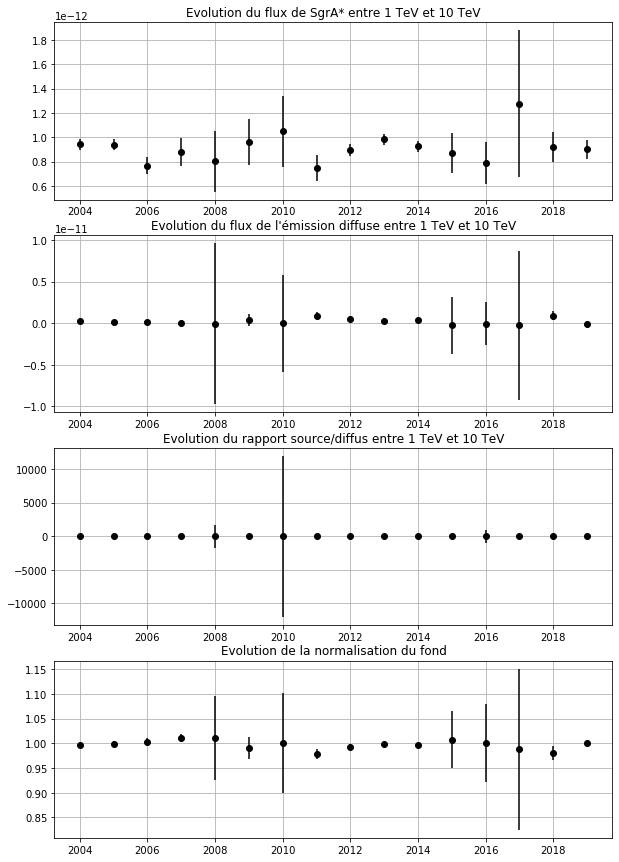

In [16]:
emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
norms = []
norms_err = []


for year in range(2004,2020):
    dif , GC, amp, amp_err, ampdiff, amp_errdiff = CalculateFluxFromModels(year, emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
    
    norms.append(results_per_year[year][9]['value'])
    norms_err.append(results_per_year[year][9]['error'])

plt.figure(figsize=(10,15))

resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)

yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff

bizar = []
for k in range(16):
    truc = 2*(cov_per_year[2004+k][0,1]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    bizar.append(truc)

    
# erreurs quadratiques trop simplistes car les jeux de données sont corrélées
yerr_rap = (resGC/resdiff)*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 -bizar )


ax1 = plt.subplot(4,1,1)

plt.errorbar(range(2004,2020) , resGC, yerr=yerrGC, fmt='ko')# ax=ax1)
plt.title("Evolution du flux de SgrA* entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(4,1,2)
plt.errorbar(range(2004,2020) , resdiff, yerr=yerrdiff, fmt='ko')
plt.title("Evolution du flux de l'émission diffuse entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(4,1,3)
plt.errorbar(range(2004,2020) , resGC/resdiff, yerr=yerr_rap, fmt='ko')
plt.title("Evolution du rapport source/diffus entre 1 TeV et 10 TeV")
plt.grid()


ax4 = plt.subplot(4,1,4)
plt.errorbar(range(2004,2020) , norms, yerr=norms_err, fmt='ko')# ax=ax1)
plt.title("Evolution de la normalisation du fond")
plt.grid()

#plt.savefig("../../hess_results/simu_1/GCDEflux_evolution.pdf")

## Ajustement du modèle d'évolution grâce à astropy

In [25]:
import scipy.stats as stats

from astropy.modeling import models, fitting

def chisq(obs, exp):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(exp**2)
    return chisq


def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr

### Ajustement de l'évolution de la source

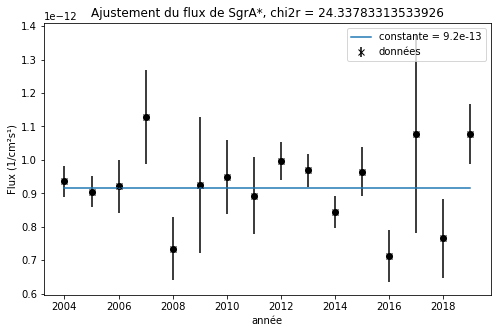

In [39]:
x = range(2004,2020)
y = resGC
y_uncs = yerrGC

x = x #np.delete(x, [13,14,15])
y = y #np.delete(y, [13,14,15])
y_uncs = y_uncs #np.delete(y_uncs, [13,14,15])


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = resGC #np.delete(resGC, [13,14,15])
A2 = t(2004)
err_bars = yerrGC
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Ajustement du flux de SgrA*, chi2r = " + str(chi2r))
plt.savefig("../../hess_results/simu_1/2004-2019/fit_flux_SgrAstar_04_19.pdf")

### Ajustement de l'émission diffuse

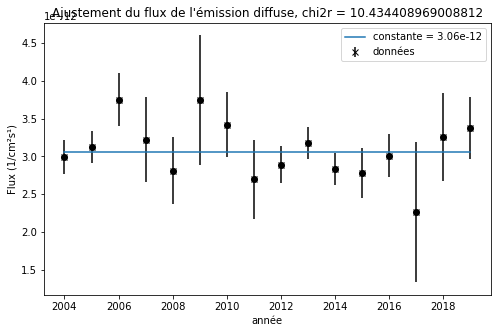

In [40]:
x = range(2004,2020)
y = resdiff
y_uncs = yerrdiff

x = x# np.delete(x, [13,14,15])
y = y#np.delete(y, [13,14,15])
y_uncs = y_uncs #np.delete(y_uncs, [13,14,15])


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)

A1 = resdiff #np.delete(resdiff, [13,14,15])
A2 = t(2004)
err_bars = yerrdiff
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Ajustement du flux de l'émission diffuse, chi2r = " + str(chi2r))
plt.savefig("../../hess_results/simu_1/2004-2019/fit_flux_DE_04_19.pdf")

### On regarde le rapport entre les 2

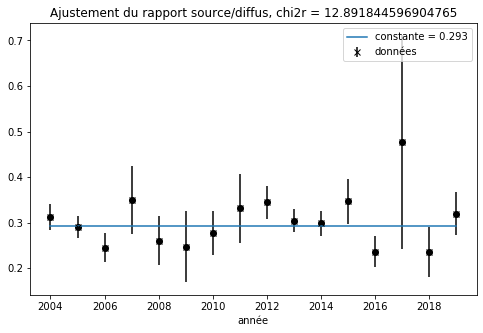

In [41]:
x = range(2004,2020)
y = resGC/resdiff

bizar = []
for k in range(16):
    truc = 2*(cov_per_year[2004+k][0,1]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    bizar.append(truc)
    
# erreurs quadratiques trop simplistes car les jeux de données sont corrélées
y_uncs = y*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 -bizar )

x = x#np.delete(x, [13,14,15])
y = y#np.delete(y, [13,14,15])
y_uncs = y_uncs#np.delete(y_uncs, [13,14,15])

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y#np.delete(y, [13,14,15])
A2 = t(2004)
err_bars = y_uncs
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 3)) )
plt.xlabel('année')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Ajustement du rapport source/diffus, chi2r = " + str(chi2r))
plt.savefig("../../hess_results/simu_1/2004-2019/fit_flux_GCsurDE_04_19.pdf")

## Autres choses

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fdde4b3e9b0>)

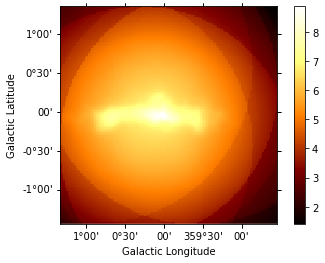

In [879]:
mapdataset_dict[2004].models[0].parameters['amplitude'].value = 0

mapdataset_dict[2004].npred().sum_over_axes().cutout(src_pos,2.8*u.deg).plot(add_cbar=True)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fdde41e4dd8>)

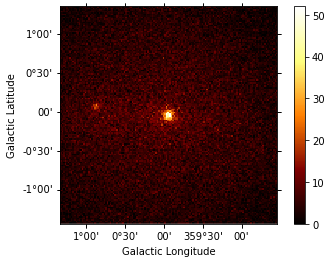

In [875]:
mapdataset_dict[2004].counts.sum_over_axes().cutout(src_pos,2.8*u.deg).plot(add_cbar=True)

In [877]:
results_per_year[2004]

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,2.102e-12,7.514e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.000e+00,0.000e+00,,nan,nan,True
index,2.300e+00,0.000e+00,,nan,nan,True
amplitude,1.109e-10,8.875e-12,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
